In [1]:
%load_ext autoreload
%autoreload 2

from meteo_lib import PROJECT  # または: from meteo_lib.paths import PROJECT
from meteo_lib.my_path_utils import DATA, OUT

import meteo_lib.meteo_lib as ml
from meteo_lib.my_path_utils import DATA, OUT

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Any, Optional, Tuple
from functools import lru_cache
import time
import matplotlib.pyplot as plt
#import japanize_matplotlib
from matplotlib.dates import DateFormatter
import datetime as dt
import matplotlib.dates as mdates

import matplotlib as mpl

mpl.rcParams["font.family"] = "IPAexGothic"   # 例：Noto Sans CJK JP でも可
mpl.rcParams["axes.unicode_minus"] = False    # －が豆腐になるのを回避
# 保存時の文字化け対策（必要なら）
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42


In [2]:
# 複数年のJMAデータを取得してひとつのDataFrameにまとめる
def make_multi_year_daily_tables_jma(
    *,
    prec: int,
    block: int,
    start_year: int,
    end_year: int,
    months = range(1, 13),
    day: int = 1,                 # JMAの「日別」は月表を返すので 1 固定でOK（関数シグネチャに合わせて渡す）
    sleep_sec: float = 0.8,       # 取得間隔（マナー＆弾かれ防止）
    max_retries: int = 3,         # 月単位取得のリトライ回数
    drop_feb29: bool = True,      # うるう日を揃えたい場合は True
#    out_dir: str = "out_csv",
    prefix: str = "daily"
) -> dict[str, pd.DataFrame]:

    Path(OUT).mkdir(parents=True, exist_ok=True)

    frames = []
    value_cols = ['平均気温', '最高気温', '最低気温']

    for year in range(start_year, end_year + 1):
        for month in months:
            last_err = None
            for trial in range(1, max_retries + 1):
                try:
                    df_m = ml.getDailyData(prec, block, year, month, day)
                    df_m = df_m.reset_index(names='日時')
                    print(df_m)

                    # 必須列チェック
#                    needed = ['年月日'] + value_cols
                    needed = ['日時'] + value_cols
                    missing = [c for c in needed if c not in df_m.columns]
                    if missing:
                        raise ValueError(f"get_DailyDataの戻り値に欠落列: {missing}")

                    # 型そろえ
                    df_m = df_m[['日時'] + value_cols].copy()
                    df_m['日時'] = pd.to_datetime(df_m['日時'], errors='coerce')
                    for c in value_cols:
                        df_m[c] = pd.to_numeric(df_m[c], errors='coerce')

                    frames.append(df_m)
                    break  # 成功
                except Exception as e:
                    last_err = e
                    if trial < max_retries:
                        time.sleep(sleep_sec)
                        continue
                    # リトライ尽きた
                    raise RuntimeError(f"JMA取得失敗: year={year}, month={month} ({e})") from e
            time.sleep(sleep_sec)  # 次の月へ

    # 全結合と整形
    df = pd.concat(frames, ignore_index=True)
    df = df.dropna(subset=['日時'])               # 日付欠損は除外
    df = df.sort_values('日時')
    df = df[~df['日時'].duplicated(keep='first')]

    if drop_feb29:
        md = df['日時']
        df = df[~((md.dt.month == 2) & (md.dt.day == 29))]

    # インデックス化（以降の処理が楽）
    df = df.set_index('日時')

    # datetime列を残したまま保存
    df_out = df[value_cols].copy()
    df_out.insert(0, '日時', df.index)  # indexを列に戻す
    df_out = df_out.reset_index(drop=True).sort_values('日時')

    out_path = Path(out_dir) / f"{prefix}_{start_year}-{end_year}.csv"
    df_out.to_csv(out_path, index=False, encoding='utf-8-sig')

    # --- 年ごとの辞書を生成 ---
    by_year = {}
    for y, g in df_out.groupby(df_out['日時'].dt.year):
        by_year[int(y)] = g.reset_index(drop=True)

    out = {
        'daily': df_out,
        'by_year': by_year
    }

    return out

In [3]:
# 1) 共通ヘルパ：辞書/DFを単一DataFrameに正規化
def _to_daily_df(res: Any) -> pd.DataFrame:
    if isinstance(res, dict):
        if 'daily' in res:
            df = res['daily'].copy()
        elif 'by_year' in res:
            df = pd.concat(res['by_year'].values(), ignore_index=True)
        else:  # {year: df}
            df = pd.concat(res.values(), ignore_index=True)
    elif isinstance(res, pd.DataFrame):
        df = res.copy()
    else:
        raise TypeError("res は {'daily':df} / {'by_year':{年:df}} / {年:df} / DataFrame を想定")
    if not pd.api.types.is_datetime64_any_dtype(df['日時']):
        df['日時'] = pd.to_datetime(df['日時'], errors='coerce')
    for c in ('最高気温','最低気温','平均気温'):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df.dropna(subset=['日時']).sort_values('日時').reset_index(drop=True)

# 2) 夏（暦年）サマリー
def summarize_summer_calendar(
    res: Any,
    *,
    summer_threshold: float = 25.0,     # 夏日の閾値
    midsummer_threshold: float = 30.0,  # 真夏日の閾値
    exhotday_threshold: float = 35.0,  # 猛暑日の閾値
    start_year: Optional[int] = None,
    end_year: Optional[int] = None
) -> pd.DataFrame:
    df = _to_daily_df(res)
    df['年'] = df['日時'].dt.year
    if start_year is None: start_year = int(df['年'].min())
    if end_year   is None: end_year   = int(df['年'].max())

    is_summer = df['最高気温'] >= summer_threshold
    first_ = df.loc[is_summer].groupby('年')['日時'].min().rename('初夏日')
    last_  = df.loc[is_summer].groupby('年')['日時'].max().rename('最終夏日')
    cnt    = is_summer.groupby(df['年']).sum().astype(int).rename('夏日日数')

    is_midsummer = df['最高気温'] >= midsummer_threshold
    mid_first_ = df.loc[is_midsummer].groupby('年')['日時'].min().rename('初真夏日')
    mid_last_  = df.loc[is_midsummer].groupby('年')['日時'].max().rename('最終真夏日')
    mid_cnt    = is_midsummer.groupby(df['年']).sum().astype(int).rename('真夏日日数')

    is_exsummer = df['最高気温'] >= exhotday_threshold
    ex_first_ = df.loc[is_exsummer].groupby('年')['日時'].min().rename('初猛暑日')
    ex_last_  = df.loc[is_exsummer].groupby('年')['日時'].max().rename('最終猛暑日')
    ex_cnt    = is_exsummer.groupby(df['年']).sum().astype(int).rename('猛暑日日数')

    idx = pd.Index(range(start_year, end_year + 1), name='年')
    out = pd.concat([first_, cnt, last_,
                     mid_first_, mid_last_, mid_cnt,
                     ex_first_, ex_last_, ex_cnt],  axis=1).reindex(idx)
    out['初夏日_DOY']   = out['初夏日'].dt.dayofyear
    out['最終夏日_DOY'] = out['最終夏日'].dt.dayofyear

#    print(out)
    return (out.reset_index()
              .loc[:, ['年','初夏日','初夏日_DOY','夏日日数','最終夏日','最終夏日_DOY',
                       '初真夏日', '最終真夏日', '真夏日日数',
                       '初猛暑日', '最終猛暑日', '猛暑日日数']])

# 3) 冬（寒候期：前年10/1〜当年3/31、ラベル=“1月を含む年”）
def summarize_winter_coldseason(
    res: Any,
    *,
    winter_threshold: float = 0.0,          # <0℃（0℃を含めるなら inclusive_zero=True）
    inclusive_zero: bool = False,           # True で <=0℃ を冬日に
    cold_start: Tuple[int,int] = (10,1),    # 前年10/1〜
    cold_end:   Tuple[int,int] = (4,30),    # 当年4/01
    start_csyear: Optional[int] = None,     # 出力レンジ（“1月を含む年”）
    end_csyear:   Optional[int] = None,
    blank_first_initial: bool = True,
    blank_last_final:   bool = True
) -> pd.DataFrame:
    df = _to_daily_df(res)
    s_m, s_d = cold_start; e_m, e_d = cold_end

    # その日が属する“寒候期年”（1月を含む年）を付与
    def cs_year(ts: pd.Timestamp):
        m, d, y = ts.month, ts.day, ts.year
        if (m > s_m) or (m == s_m and d >= s_d):  # 前年側 → 翌年ラベル
            return y + 1
        if (m < e_m) or (m == e_m and d <= e_d):  # 当年側 → 当年ラベル
            return y
        return pd.NA
    df['寒候期年'] = df['日時'].apply(cs_year)

    valid = df['寒候期年'].dropna().astype(int)
    if valid.empty:
        return pd.DataFrame(columns=['寒候期年','初冬日','初冬日_DOY',
                                     '最終冬日','最終冬日_DOY',
                                     '初真冬日','最終真冬日'])
    if start_csyear is None: start_csyear = int(valid.min())
    if end_csyear   is None: end_csyear   = int(valid.max())
    idx = pd.Index(range(start_csyear, end_csyear + 1), name='寒候期年')

    in_cs = df['寒候期年'].notna()
    is_winter = (df['最低気温'] <= winter_threshold) if inclusive_zero else (df['最低気温'] < winter_threshold)
    is_mid_winter = (df['最高気温'] <= winter_threshold) if inclusive_zero else (df['最高気温'] < winter_threshold)

    first_ = df.loc[in_cs & is_winter].groupby('寒候期年')['日時'].min().rename('初冬日')
    last_  = df.loc[in_cs & is_winter].groupby('寒候期年')['日時'].max().rename('最終冬日')
  #  cnt    = ((in_cs & is_winter).groupby(df['寒候期年']).sum().astype('Int64').rename('冬日日数'))

    mid_first_ = df.loc[in_cs & is_mid_winter].groupby('寒候期年')['日時'].min().rename('初真冬日')
    mid_last_  = df.loc[in_cs & is_mid_winter].groupby('寒候期年')['日時'].max().rename('最終真冬日')
  #  mid_cnt    = ((in_cs & is_mid_winter).groupby(df['寒候期年']).sum().astype('Int64').rename('真冬日日数'))

  #  out = pd.concat([first_, cnt, last_, mid_first_, mid_cnt, mid_last_ ], axis=1).reindex(idx)
    out = pd.concat([first_, last_, mid_first_, mid_last_ ], axis=1).reindex(idx)
    out['初冬日_DOY']  = out['初冬日'].dt.dayofyear
    out['最終冬日_DOY'] = out['最終冬日'].dt.dayofyear
    out = (out.reset_index()
             .loc[:, ['寒候期年','初冬日','初冬日_DOY','最終冬日','最終冬日_DOY',
                      '初真冬日','最終真冬日']])

    # 端年度のブランク指定
    if not out.empty:
        if blank_first_initial:
            out.loc[out.index[0], ['初冬日','初冬日_DOY']] = [pd.NaT, pd.NA]
        if blank_last_final:
            out.loc[out.index[-1], ['最終冬日','最終冬日_DOY']] = [pd.NaT, pd.NA]
    return out

# 3.5) 冬（寒候期：前年10/1〜当年3/31、ラベル=“1月を含む年”）
#    冬日日数、真冬日日数は暦年でカウント

def summarize_winter_calendar(
    res: Any,
    *,
    winter_threshold: float = 0.0,      # <0℃（inclusive_zero=True なら <=0℃）
    inclusive_zero: bool = False,
    start_year: Optional[int] = None,
    end_year: Optional[int] = None,
) -> pd.DataFrame:
    df = _to_daily_df(res)
    # ★ これが無くて KeyError: '年' が出ていた
    df['年'] = df['日時'].dt.year

    if start_year is None:
        start_year = int(df['年'].min())
    if end_year is None:
        end_year = int(df['年'].max())
    idx = pd.Index(range(start_year, end_year + 1), name='年')

    if inclusive_zero:
        is_winter     = df['最低気温'] <= winter_threshold   # 冬日：最低気温
        is_mid_winter = df['最高気温'] <= winter_threshold   # 真冬日：最高気温
    else:
        is_winter     = df['最低気温']  < winter_threshold
        is_mid_winter = df['最高気温']  < winter_threshold

    cnt     = is_winter.groupby(df['年']).sum().astype('Int64').rename('冬日日数')     # 暦年
    mid_cnt = is_mid_winter.groupby(df['年']).sum().astype('Int64').rename('真冬日日数')  # 暦年

    out = pd.concat([cnt, mid_cnt], axis=1).reindex(idx, fill_value=0).astype('Int64')
    return out.reset_index()


# 4) 結合：年（暦年）と寒候期年を突き合わせ＆自動補完
def combine_summer_winter(summer_df: pd.DataFrame, winter_df: pd.DataFrame,
                          winter_cnt_df: pd.DataFrame) -> pd.DataFrame:
    merged = pd.merge(
        summer_df, winter_df, left_on='年', right_on='寒候期年', how='outer'
    )
    # 年の補完（夏 or 冬のどちらかにしか無い年を救う）
    if '年' in merged.columns and '寒候期年' in merged.columns:
        merged['年'] = merged['年'].astype('Int64')
        merged['寒候期年'] = merged['寒候期年'].astype('Int64')
        merged['年'] = merged['年'].fillna(merged['寒候期年'])
        merged = merged.drop(columns=['寒候期年'])

    merged = pd.merge(
        merged, winter_cnt_df, left_on='年', right_on='年', how='outer'
    )

    cols = ['年','初夏日','初夏日_DOY','夏日日数','最終夏日','最終夏日_DOY',
            '初真夏日', '真夏日日数', '最終真夏日', '初猛暑日', '猛暑日日数', '最終猛暑日',
            '初冬日','初冬日_DOY','冬日日数','最終冬日','最終冬日_DOY',
            '初真冬日','真冬日日数','最終真冬日']
    return (merged[[c for c in cols if c in merged.columns]]
            .sort_values('年').reset_index(drop=True))


def add_gaps_for_summary(summary: pd.DataFrame) -> pd.DataFrame:
    """
    summary（combine_summer_winter_tables の出力を想定）に3列を追加:
      - '最終夏日→翌寒候期初冬日_すき間(日)'
      - '初冬日→最終冬日(同寒候期)_すき間(日)'
      - '初夏日→最終夏日(同暦年)_すき間(日)'
    いずれも端点除外（差の日数から1を引く）。欠損 or 差が負なら NA。
    """
    df = summary.copy().sort_values('年').reset_index(drop=True)

    def gap_exclusive(later, earlier):
        if pd.isna(later) or pd.isna(earlier):
            return pd.NA
        d = (later - earlier).days - 1
        return d if d >= 0 else pd.NA

    # 1) 春期間（最終冬日〜初夏日）
    df['春期間'] = (df['初夏日'] - df['最終冬日']).dt.days - 1

    # 2) 夏期間（初夏日→最終夏日）
    df['夏期間'] = [
        gap_exclusive(row['最終夏日'], row['初夏日']) for _, row in df.iterrows()
    ]

    # 3) 秋期間（最終夏日〜翌寒候期の初冬日）（例: 1961年は 1962行の初冬日＝1961-11-14 を使用）
    next_season_first_winter = df['初冬日'].shift(-1)  # Y+1 シーズンの初冬日
    df['秋期間'] = [
        gap_exclusive(nfw, ls) for nfw, ls in zip(next_season_first_winter, df['最終夏日'])
    ]

    # 4) 冬期間（初冬日→最終冬日（同一寒候期））
    df['冬期間'] = [
        gap_exclusive(row['最終冬日'], row['初冬日']) for _, row in df.iterrows()
    ]

    return df


# 5) 取得→サマリー→結合を1発で（冬のため開始年-1で自動取得）
def build_summary_for_place(
    *, pref: str, place: str, start_year: int, end_year: int,
    summer_threshold: float = 25.0,
    midsummer_threshold: float = 30.0,
    exhotday_threshold: float = 35.0,
    winter_threshold: float = 0.0,
    inclusive_zero: bool = False,
    cold_start=(10,1), cold_end=(3,31)
) -> pd.DataFrame:
    info = ml.getBlock(pref, place)
    prec, block = info['prec'], info['block']
    
    # ★ キャッシュ経路：前年Q4も含めて取得
    res = build_daily_with_cache(
        prec=prec, block=block,
        start_year=start_year, end_year=end_year,
        fetch_func=ml.get_DailyData,
        need_prev_year_for_coldseason=True
    )

    summer = summarize_summer_calendar(
        res, summer_threshold=summer_threshold,
        midsummer_threshold=midsummer_threshold,
        exhotday_threshold=exhotday_threshold,
        start_year=start_year, end_year=end_year
    )
    winter = summarize_winter_coldseason(
        res, winter_threshold=winter_threshold, inclusive_zero=inclusive_zero,
        cold_start=cold_start, cold_end=cold_end,
        start_csyear=start_year, end_csyear=end_year,
        blank_first_initial=True, blank_last_final=True
    )
    winter_cnt = summarize_winter_calendar(
        res, winter_threshold=winter_threshold, inclusive_zero=inclusive_zero,
        start_year=start_year, end_year=end_year,
    )

    summary = combine_summer_winter(summer, winter, winter_cnt)

    # ここでギャップ列を追加
    summary = add_gaps_for_summary(summary)

    return summary


In [4]:
# =========================
#  JMA 高速ローダ（キャッシュ付）
#  - 月次Parquetキャッシュ
#  - dtype固定（float32）
#  - 並列読み込み（ローカルParquetのみ）
# =========================

from __future__ import annotations
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import pandas as pd
import numpy as np
import os

# ---- 設定 ----
CACHE_DIR = Path("jma_cache_parquet")   # キャッシュのルート
PARQUET_COMPRESSION = None              # 実行時に zstd/snappy を選ぶ（Noneで自動）

# ---- 圧縮方式の自動選択 ----
def _choose_parquet_compression() -> str:
    # pyarrowがzstdをサポートしていなければsnappyへ
    # 失敗したら非圧縮（None）にフォールバック
    try:
        import pyarrow
        from pyarrow import codec
        # 新旧でAPIが異なるので雑にtry
        for name in ("zstd", "ZSTD"):
            try:
                codec.is_available(name)
                return "zstd"
            except Exception:
                pass
        return "snappy"
    except Exception:
        return None

if PARQUET_COMPRESSION is None:
    PARQUET_COMPRESSION = _choose_parquet_compression()

# ---- ヘルパ：月ファイルのパス ----
def _month_cache_path(prec: int, block: int, year: int, month: int) -> Path:
    return CACHE_DIR / f"{prec}_{block}" / f"{year:04d}" / f"{year:04d}-{month:02d}.parquet"

# ---- 型そろえ（高速I/O向けに軽量dtypeで統一）----
DTYPE_MAP = {
    "平均気温": "float32",
    "最高気温": "float32",
    "最低気温": "float32",
}
DATE_COL = "日時"
VALUE_COLS = ["平均気温", "最高気温", "最低気温"]

def _coerce_daily_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df[[DATE_COL] + VALUE_COLS].copy()
    # 既にdatetimeなら速い・未変換ならformat指定で高速化
    if not pd.api.types.is_datetime64_any_dtype(df[DATE_COL]):
        df[DATE_COL] = pd.to_datetime(df[DATE_COL], format="%Y-%m-%d", errors="coerce")
    for c in VALUE_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype(DTYPE_MAP[c])
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)
    return df

# ---- 1ヶ月取得＋キャッシュ保存（未キャッシュ時のみ）----
def load_month_cached(prec: int, block: int, year: int, month: int,
                      fetch_func,
                      *, force_refresh: bool = False,
                      polite_sleep_sec: float = 0.8,
                      max_retries: int = 3) -> pd.DataFrame:
    """
    fetch_func(prec, block, year, month, day) -> DataFrame
    未キャッシュなら取得→Parquet保存、既にあれば読み込みのみ。
    """
    path = _month_cache_path(prec, block, year, month)
    path.parent.mkdir(parents=True, exist_ok=True)

    if path.exists() and not force_refresh:
        # Parquetは型保持のため超速
        return pd.read_parquet(path)

    last_err = None
    for trial in range(1, max_retries + 1):
        try:
            # JMAは月表を day=1 で取得する実装を想定
            df_m = fetch_func(prec, block, year, month, 1)
            df_m = df_m.reset_index(names="日時")
            df_m = _coerce_daily_df(df_m)
            df_m.to_parquet(path, index=False, compression=PARQUET_COMPRESSION)
            return df_m
        except Exception as e:
            last_err = e
            if trial < max_retries:
                time.sleep(polite_sleep_sec)
                continue
            raise RuntimeError(f"月データ取得失敗: {year}-{month:02d} ({e})") from e
    # 到達しないはず
    raise last_err  # noqa

# ---- 期間読み込み（キャッシュ優先、未キャッシュのみ取得）----
def make_multi_year_cached(prec: int, block: int,
                           start_year: int, end_year: int,
                           fetch_func,
                           *, drop_feb29: bool = True,
                           parallel_read: bool = True,
                           max_workers: int | None = None) -> pd.DataFrame:
    """
    指定期間の全月を用意（キャッシュがあれば読む／無ければ取得・保存）。
    読み込み段階はParquetを並列で読むことで高速化（ネット取得は逐次）。
    """
    # まずファイルの存在を調べ、未キャッシュ分だけ順次取得して保存
    tasks = []
    for y in range(start_year, end_year + 1):
        for m in range(1, 13):
            p = _month_cache_path(prec, block, y, m)
            tasks.append((y, m, p))
    # 未キャッシュを先に取得（逐次＝礼儀）
    for (y, m, p) in tasks:
        if not p.exists():
            _ = load_month_cached(prec, block, y, m, fetch_func, force_refresh=False)

    # ここまで来たら全月がParquetで存在 → 並列で読み込む
    def _read_parquet(pth: Path) -> pd.DataFrame:
        return pd.read_parquet(pth)

    frames: list[pd.DataFrame] = []
    if parallel_read:
        if max_workers is None:
            max_workers = min(32, (os.cpu_count() or 4))
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            futs = {ex.submit(_read_parquet, p): (y, m) for (y, m, p) in tasks}
            for fu in as_completed(futs):
                df_m = fu.result()
                frames.append(df_m)
    else:
        for (_, _, p) in tasks:
            frames.append(pd.read_parquet(p))

    df = pd.concat(frames, ignore_index=True)
    # 重複日除去＆整形
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL)
    df = df[~df[DATE_COL].duplicated(keep="first")]
    if drop_feb29:
        md = df[DATE_COL]
        df = df[~((md.dt.month == 2) & (md.dt.day == 29))]
    return df.reset_index(drop=True)


# ---- 既存フローとの接続ユーティリティ（res={'daily': df} を返す）----
def build_daily_with_cache(*, prec: int, block: int,
                           start_year: int, end_year: int,
                           fetch_func,
                           need_prev_year_for_coldseason: bool = True) -> dict[str, pd.DataFrame]:
    """
    冬の寒候期のために開始年を自動で -1 して取得するオプション付き。
    """
    s = start_year - 1 if need_prev_year_for_coldseason else start_year
    df = make_multi_year_cached(
        prec, block, start_year=s, end_year=end_year,
        fetch_func=fetch_func,
        drop_feb29=True,
        parallel_read=True
    )
    return {"daily": df}


In [5]:
"""
prec_list = {
    "宗谷総合振興局":11, "上川総合振興局":12, "留萌振興局":13, "石狩振興局":14,
    "空知総合振興局":15, "後志総合振興局":16, "オホーツク総合振興局":17,
    "根室振興局":18, "釧路総合振興局":19, "十勝総合振興局":20, "胆振総合振興局":21,
    "日高振興局":22, "渡島総合振興局":23, "檜山振興局":24,
    "青森県":31, "秋田県":32, "岩手県":33, "宮城県":34, "山形県":35, "福島県":36,
    "茨城県":40, "栃木県":41, "群馬県":42, "埼玉県":43, "東京都":44, "千葉県":45,
    "神奈川県":46, "長野県":48, "山梨県":49, "静岡県":50, "愛知県":51, "岐阜県":52,
    "三重県":53, "新潟県":54, "富山県":55, "石川県":56, "福井県":57,
    "滋賀県":60, "京都府":61, "大阪府":62, "兵庫県":63, "奈良県":64, "和歌山県":65,
    "岡山県":66, "広島県":67, "島根県":68, "鳥取県":69, "徳島県":71, "香川県":72,
    "愛媛県":73, "高知県":74,
    "山口県":81, "福岡県":82, "大分県":83, "長崎県":84, "佐賀県":85, "熊本県":86,
    "宮崎県":87, "鹿児島県":88,
    "沖縄県":91, "南大東村":92, "北大東村":92, "宮古島市":93, "宮古郡":93,
    "石垣市":94, "八重山郡":94}
"""
# 1) 地点指定
pref, place, start_year, end_year = "宮城県", "仙台", 1926, 2024
info = ml.getBlock(pref, place)
print(info)
prec = info['prec']
block = info['block']
st_name = info['Name_2']
print(st_name)
# 2) 高速ロード（未キャッシュは取得→保存、以降は爆速ロード）
res = build_daily_with_cache(
    prec=prec, block=block,
    start_year=start_year, end_year=end_year,
    fetch_func=ml.get_DailyData,
    need_prev_year_for_coldseason=True  # 冬（前年10月）を含める用に開始年-1で取得
)
drive_path = "/Users/takumi/projects/JMA-data"
drive_path = Path(drive_path)
outdir = drive_path / "outputs"
outdir.mkdir(parents=True, exist_ok=True)
basename= f"日毎データ_{place}"
ext1 = ".parquet"
ext2 = ".csv"
#print(outfile)
df_daily = res['daily']
#print(df_daily, place)
outfile1 = (outdir / basename).with_suffix(ext1)
outfile2 = (outdir / basename).with_suffix(ext2)
df_daily.to_parquet(outfile1, index=False, compression='zstd')
df_daily.to_csv(outfile2, index=False, encoding='utf-8-sig')

# 3) 以降は従来フローのまま
summary = build_summary_for_place(
    pref=pref, place=place,
    start_year=start_year, end_year=end_year,     # ← 表示レンジ
    summer_threshold=25.0,
    midsummer_threshold=30.0,
    exhotday_threshold=35.0,
    winter_threshold=0.0,
    inclusive_zero=False,               # True で 0.0℃ も冬日に含める
    cold_start=(10,1), cold_end=(4,30)  # 1月を含む冬期間：前年10/1〜当4/30
)
display(summary)
summary.to_parquet(OUT / f'日毎データ_{place}_summary.parquet', index=False, compression='zstd')
summary.to_csv(OUT / f'日毎データ_{place}_summary.csv', index=False, encoding='utf-8-sig')

print("Finish")

{'prec': 34, 'block': 47590, 'Name_2': 'SENDAI', 'Alt': 39.0, 'H_Anemo': 52.0, 'Lat': 38.262, 'Lon': 140.897}
SENDAI


,年,初夏日,初夏日_DOY,夏日日数,最終夏日,最終夏日_DOY,初真夏日,真夏日日数,最終真夏日,初猛暑日,...,冬日日数,最終冬日,最終冬日_DOY,初真冬日,真冬日日数,最終真冬日,春期間,夏期間,秋期間,冬期間
0,1926,NaT,NaN,0,NaT,NaN,NaT,0,NaT,NaT,...,33,NaT,NaN,NaT,0,NaT,NaN,<NA>,<NA>,<NA>
1,1927,1927-05-21,141.0,75,1927-10-03,276.0,1927-07-17,14,1927-08-24,NaT,...,109,1927-03-29,88.0,1927-01-19,9,1927-02-05,52.0,134,48,140
2,1928,1928-06-09,161.0,54,1928-09-25,269.0,1928-07-16,5,1928-09-14,NaT,...,104,1928-04-21,112.0,1928-01-13,2,1928-02-08,48.0,107,46,151
3,1929,1929-05-31,151.0,69,1929-10-08,281.0,1929-07-11,32,1929-09-03,1929-07-18,...,106,1929-04-06,96.0,1929-01-03,5,1929-03-03,54.0,129,42,145
4,1930,1930-04-19,109.0,71,1930-09-23,266.0,1930-07-03,20,1930-09-03,NaT,...,100,1930-03-25,84.0,1930-01-08,2,1930-01-09,24.0,156,49,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2020,2020-05-02,123.0,90,2020-09-23,267.0,2020-05-02,32,2020-09-09,2020-08-15,...,31,2020-02-12,43.0,NaT,1,NaT,79.0,143,82,74
95,2021,2021-05-08,128.0,88,2021-10-15,288.0,2021-07-06,28,2021-08-30,NaT,...,56,2021-03-09,68.0,2020-12-31,2,2021-01-08,59.0,159,63,83
96,2022,2022-04-13,103.0,94,2022-10-04,277.0,2022-06-20,32,2022-08-23,2022-06-25,...,66,2022-03-23,82.0,NaT,0,NaT,20.0,173,59,94
97,2023,2023-04-14,104.0,117,2023-10-03,276.0,2023-05-18,66,2023-09-20,2023-07-16,...,54,2023-03-05,64.0,2023-01-25,1,2023-01-25,39.0,171,74,91


Finish


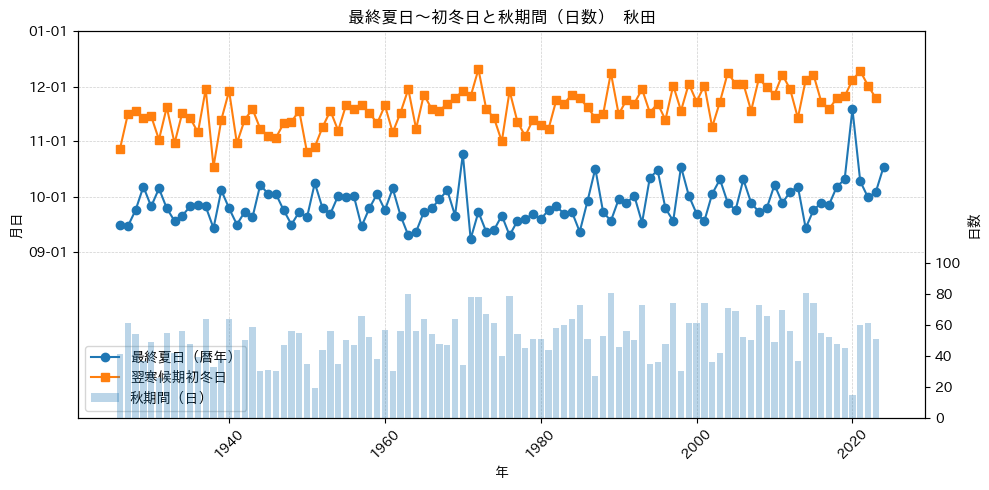

In [8]:
# データチェックのための作図
# ---- 前提 ----
# summary: DataFrame に以下の列があること:
#   年, 最終夏日, 初冬日, 秋期間

REF_YEAR = 2001
FALL_COL = "秋期間"  # ←計算済みの列名をそのまま使用

df = summary.copy().sort_values("年").reset_index(drop=True)
df["翌寒候期初冬日"] = df["初冬日"].shift(-1)  # 折れ線用：翌シーズンの初冬日

def to_refdate(s: pd.Series) -> pd.Series:
    # 年を消して「月日だけ」を基準年に載せ替え（NaTはNaTのまま）
    return pd.to_datetime(
        np.where(s.notna(), s.dt.strftime(f"{REF_YEAR}" + "-%m-%d"), pd.NaT),
        errors="coerce"
    )

final_summer_ref = to_refdate(df["最終夏日"])
next_first_winter_ref = to_refdate(df["翌寒候期初冬日"])
x = df["年"].astype(int).values

fig, ax1 = plt.subplots(figsize=(10, 5))

# 左軸：月日（折れ線）
ax1.plot(x, final_summer_ref, marker="o", label="最終夏日（暦年）")
ax1.plot(x, next_first_winter_ref, marker="s", label="翌寒候期初冬日")
ax1.set_ylabel("月日")
ax1.yaxis.set_major_formatter(DateFormatter("%m-%d"))
ax1.set_xlabel("年")
ax1.tick_params(axis='x', labelrotation=45)
y1_min = dt.date(REF_YEAR, 6, 1)
y1_max = dt.date(REF_YEAR + 1, 1, 1)
ax1.set_ylim(y1_min, y1_max)
# --- y軸ラベルを9月〜12月の1か月ごとに ---
tick_dates = pd.date_range(start=f"{REF_YEAR}-09-01", end=f"{REF_YEAR + 1}-01-01", freq="MS")
#tick_dates = pd.date_range(start=f"{REF_YEAR}-09-01", end=f"{REF_YEAR}-12-01", freq="MS")
ax1.set_yticks(tick_dates)
ax1.yaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))


# 右軸：秋期間（日）（棒）
ax2 = ax1.twinx()
y = pd.to_numeric(df[FALL_COL], errors='coerce').fillna(0.0)
ax2.bar(x, y.values.astype("float"), alpha=0.3, label="秋期間（日）")
ax2.set_ylabel("日数")
ax2.set_ylim(0, 250)
ticks = list(range(0, 101, 20))
ax2.set_yticks(ticks)


# 凡例（統合）
handles, labels = [], []
for ax in (ax1, ax2):
    h, l = ax.get_legend_handles_labels()
    handles += h; labels += l
seen, h2, l2 = set(), [], []
for h, l in zip(handles, labels):
    if l not in seen:
        seen.add(l); h2.append(h); l2.append(l)
ax1.legend(h2, l2, loc="best")

ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.title(f"最終夏日〜初冬日と秋期間（日数）  {place}")
plt.tight_layout()

#plt.savefig(f'{place}_{start_year}-{end_year}_秋日数.png')

plt.show()
